In [161]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

In [162]:
runner = pd.read_csv("../../../output/data_clean/cleaned_runner.csv", index_col=0)
race = pd.read_csv("../../../output/data_clean/cleaned_race_equivalent_distance.csv", index_col= 0)
runner.age_range = pd.Categorical(
    runner.age_range, categories=['16-25','26-40','40-60','61+','Undefined'],ordered=True
)
runner = runner.dropna()

In [163]:
race = race.assign(
    date = pd.to_datetime(race[['month', 'day', 'year']])
)

In [164]:
join = pd.merge(runner, race, left_on="race_year_id", right_on="race_year_id", how="left")
join = join.loc[join.age_range != "Undefined"]

In [165]:
join = join.assign(
    relative_ranking = join.ranking / join.frequency_in_ranking
)

## Prédiction de performance pour les coureurs en 2019

In [168]:
def runner_profile(join, race, race_year_id_to_predict):
    #Collect data from course
    race_to_predict = race.loc[race.race_year_id == race_year_id_to_predict]
    race_year_id = race_to_predict.iloc[0]['race_year_id']
    date_to_predict = race_to_predict.iloc[0]['date']
    distance_to_predict = race_to_predict.iloc[0]['equivalent_distance']
    #Return df
    df = pd.DataFrame()
    
    unique_runners = join.loc[join.race_year_id == race_year_id]['runner_id'].unique()
    for runner in tqdm(unique_runners):
        runner_info = join.loc[(join.runner_id == runner) & (join.date == date_to_predict)]
        runner_past = join.loc[(join.runner_id == runner) & (join.date < date_to_predict)]
        
        # Data processing
        #General data
        runner_id =  runner
        age = runner_info['age'].iloc[0]
        gender = runner_info['gender'].iloc[0]
        nationality = runner_info['nationality'].iloc[0]
        
        #Processed data
        has_run = 0
        total_distance = 0
        total_races = 0
        has_run_last_year = 0
        has_run_equivalent_course = 0
        avg_course_per_year = 0
        distance_previous_year = 0
        ranking_score = 0
        
        if runner_past.size > 0: 
            has_run = 1
            total_distance =  runner_past.equivalent_distance.sum()
            total_races = runner_past.shape[0]
            
            for i in range(len(runner_past)):
                ranking_score += (1 / runner_past.iloc[i,1]) * np.log(runner_past.iloc[i,22] - 2010)
               
            last_year_df = runner_past.loc[runner_past.date > date_to_predict - pd.DateOffset(years=1)]
            if len(last_year_df) > 0:
                has_run_last_year = 1
                distance_previous_year = last_year_df.equivalent_distance.sum()
            if len(runner_past.loc[runner_past.equivalent_distance >= distance_to_predict -10 ]):
                has_run_equivalent_course = 1
            
            year_interval = runner_past.year.max()- runner_past.year.min()
            if year_interval != 0:
                avg_course_per_year = total_races / year_interval
            
            
            
        df = df.append({'runner_id': runner_id, 
                        'age': age, 
                        'gender': gender, 
                        'nationality':nationality,
                        'total_distance': total_distance,
                        'distance_previous_year': distance_previous_year,
                        'total_races': total_races,
                        'has_run': has_run,
                        'has_run_last_year': has_run_last_year,
                        'has_run_equivalent_course': has_run_equivalent_course,
                        'avg_course_per_year': avg_course_per_year,
                        'ranking_score': ranking_score
                       }, ignore_index = True)
    return df

In [169]:
runner_p = runner_profile(join,race, 39881)

100%|███████████████████████████████████████| 1557/1557 [00:22<00:00, 70.74it/s]


In [170]:
runner_p

,runner_id,age,gender,nationality,total_distance,distance_previous_year,total_races,has_run,has_run_last_year,has_run_equivalent_course,avg_course_per_year,ranking_score
0,CAPELLPauESPM30.0,30.0,M,ESP,741.80,229.9,3.0,1.0,1.0,1.0,1.500000,3.561264
1,THEVENARDXavierFRAM33.0,33.0,M,FRA,1579.93,512.0,6.0,1.0,1.0,1.0,1.000000,8.068447
2,HAWKERScottNZLM34.0,34.0,M,NZL,532.28,0.0,2.0,1.0,0.0,1.0,0.666667,0.198562
3,OWENSTomGBRM40.0,40.0,M,GBR,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
4,SYMONDSAndyGBRM40.0,40.0,M,GBR,268.40,0.0,1.0,1.0,0.0,1.0,0.000000,0.121619
...,...,...,...,...,...,...,...,...,...,...,...,...
1552,CHUILokNinJoeHKGM42.0,42.0,M,HKG,483.80,0.0,2.0,1.0,0.0,0.0,2.000000,0.024805
1553,TSEHonShingHKGM62.0,62.0,M,HKG,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
1554,CLEMOTChristopheFRAM52.0,52.0,M,FRA,771.50,503.1,3.0,1.0,1.0,1.0,1.500000,0.014862
1555,LOPEZHIDALGORafaelESPM43.0,43.0,M,ESP,1074.28,0.0,4.0,1.0,0.0,1.0,1.000000,0.008425


In [175]:
actual_values = join.loc[join.race_year_id == 39881]
actual_values = actual_values[['runner_id','ranking','time_in_seconds']]

In [177]:
join_test = pd.merge(runner_p, actual_values, left_on="runner_id", right_on="runner_id", how="left")

In [178]:
join_test

,runner_id,age,gender,nationality,total_distance,distance_previous_year,total_races,has_run,has_run_last_year,has_run_equivalent_course,avg_course_per_year,ranking_score,ranking,time_in_seconds
0,CAPELLPauESPM30.0,30.0,M,ESP,741.80,229.9,3.0,1.0,1.0,1.0,1.500000,3.561264,1.0,73147.0
1,THEVENARDXavierFRAM33.0,33.0,M,FRA,1579.93,512.0,6.0,1.0,1.0,1.0,1.000000,8.068447,2.0,76076.0
2,HAWKERScottNZLM34.0,34.0,M,NZL,532.28,0.0,2.0,1.0,0.0,1.0,0.666667,0.198562,3.0,78484.0
3,OWENSTomGBRM40.0,40.0,M,GBR,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,4.0,79469.0
4,SYMONDSAndyGBRM40.0,40.0,M,GBR,268.40,0.0,1.0,1.0,0.0,1.0,0.000000,0.121619,5.0,81315.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1554,CHUILokNinJoeHKGM42.0,42.0,M,HKG,483.80,0.0,2.0,1.0,0.0,0.0,2.000000,0.024805,1552.0,167493.0
1555,TSEHonShingHKGM62.0,62.0,M,HKG,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1553.0,167494.0
1556,CLEMOTChristopheFRAM52.0,52.0,M,FRA,771.50,503.1,3.0,1.0,1.0,1.0,1.500000,0.014862,1554.0,167592.0
1557,LOPEZHIDALGORafaelESPM43.0,43.0,M,ESP,1074.28,0.0,4.0,1.0,0.0,1.0,1.000000,0.008425,1555.0,167813.0


<AxesSubplot:xlabel='axis1', ylabel='axis2'>

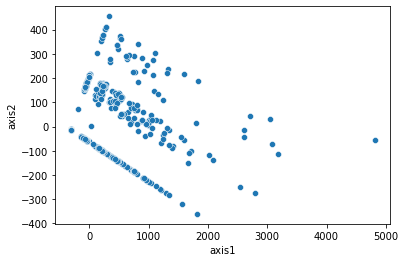

In [188]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

df = join_test[['age','total_distance','distance_previous_year','total_races','has_run','has_run_last_year','has_run_equivalent_course','avg_course_per_year','ranking_score']]
cls = PCA(n_components=5)
pcs = cls.fit_transform(df)

X = pd.DataFrame(pcs, columns=["axis1", "axis2","axis3","axis4","axis5"])
X.index = df.index
X = pd.concat([X, join_test.gender], axis=1)


sns.scatterplot(x = "axis1", y = "axis2",data = X)

In [189]:
cls.explained_variance_ratio_

array([9.52489950e-01, 4.72375925e-02, 2.67506422e-04, 1.76882261e-06,
       1.48898616e-06])

In [190]:
cls.components_

array([[ 1.65833160e-03,  9.86917657e-01,  1.61152521e-01,
         4.18372152e-03,  6.69247371e-04,  4.85242917e-04,
         5.22104239e-04,  1.26172389e-03,  7.76174629e-04],
       [-8.20236680e-03, -1.61134471e-01,  9.86892608e-01,
        -6.61577930e-04,  5.24240737e-04,  3.23608321e-03,
         8.05489605e-05,  3.08580939e-04,  3.10597436e-04],
       [ 9.99908334e-01, -2.94746216e-03,  7.83195654e-03,
        -1.30731870e-03, -3.84831724e-04, -1.81668632e-04,
         1.65985102e-03,  1.24027839e-03, -1.03495063e-02],
       [ 9.65282517e-03, -3.26087613e-04,  1.51713577e-04,
         9.56581193e-02, -2.66341580e-01, -1.65798133e-02,
        -3.33032598e-01, -3.24614845e-01,  8.38604783e-01],
       [ 1.83138429e-03, -1.70648228e-03, -4.99766640e-04,
         1.28785119e-01, -9.29985043e-02,  4.65855293e-03,
        -1.79684831e-01,  9.38634827e-01,  2.47821460e-01]])